In [ ]:
!pip install langchain faiss-cpu transformers

In [ ]:
!pip install optuna

In [ ]:
!pip install langchain_openai

In [ ]:
!pip install -U langchain-community

In [ ]:
 !pip install adjustText

In [ ]:

!pip install mlflow

!pip install faiss

!pip install transformers sentence-transformers

!pip install gitpython


In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings, OpenAIEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel, AutoTokenizer
from langchain.vectorstores import FAISS
import faiss
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
from sentence_transformers import SentenceTransformer
import json
import random
import umap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import time
import os
import pickle
from typing import List
import mlflow
from google.colab import userdata

path = "/content/drive/MyDrive/GitHubRepositoriesProject/"

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

In [ ]:
clean_df.shape

(11711, 11)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

### Preparing the **CustomCodeBERTEmbeddings** Model  
The **CodeBERT** model is designed for code-related data. It is based on **BERT** and trained with code data. This model allows generating representations of texts using a **tokenizer** and a **model**.  

### The **embed_documents** Function  
This function generates embeddings for each given text by:  
- **Tokenization:** Breaking down the text into tokens.  
- **Text Splitting:** Dividing texts based on length to fit the model’s input limit.  
- **Batch Processing:** Producing embeddings in batches to improve efficiency.

In [ ]:
clean_df.dropna(subset = 'Topics',inplace = True)
clean_df.shape

(11699, 11)

In [ ]:
clean_df.head(2)

,Name,Description,URL,Created At,Updated At,Size,Stars,Topics,Overlap_Score,Common_Words,Year
0,PyPOTS,toolboxlibrary data mining partially observed ...,https://github.com/WenjieDu/PyPOTS,2022-03-29 14:22:47,2023-09-25 04:20:18,7812,438,"classification, clustering, data mining, forec...",37,"['data', 'forecasting', 'incomplete', 'irregul...",2022
1,changedetection.io,best simplest free open source website change ...,https://github.com/dgtlmoon/changedetection.io,2021-01-27 16:03:30,2023-09-21 11:00:40,6801,11908,"back in stock, change alert, change detection,...",27,"['change', 'defacement', 'detection', 'monitor...",2021


In [ ]:
clean_df["Topics"].head()

,Topics
0,"classification, clustering, data mining, forec..."
1,"back in stock, change alert, change detection,..."
2,"aco, ant colony optimization, artificial bee c..."
3,"instagram, instagram api, instagram bot, insta..."
4,"dashboard, log analysis, log parsing, scrapy, ..."


### Understanding the Use Case  
The use case involves **highly specific technical categories** (algorithm names, library names, tool descriptions, etc.).  

### Why Simple Semantic Search Is Not Enough  
- Simple embeddings may not accurately capture the precise meaning of technical terms.  
- A model that understands technical terminology in depth is required (e.g., **CodeBERT**).  

### Evaluation Approach  
- Multiple indexes need to be evaluated to determine the most effective one.  
- Using **MLFlow** will be ideal for tracking experiments and comparing results.  

The plan is to build, test, and compare different index configurations to identify the most suitable setup for technical term retrieval.  

Would you like me to proceed with the implementation of this approach?

# Sampling

In [ ]:
def radom_samplig(df):
  return df.sample(frac=0.1, random_state=42)

sample_df = radom_samplig(clean_df)
sample_df.shape

(1170, 11)

# Embeddings

### Embedding Models Overview  

1. **CodeBERT**  
   - Transformer-based model developed by Microsoft, trained on code-documentation pairs from public repositories.  
   - **Strengths:** Excellent understanding of technical terms and code, ideal for topics related to programming languages, libraries, and algorithms.  
   - **Source:** microsoft/codebert-base  

2. **SciBERT**  
   - Model by Allen Institute for AI, trained on scientific papers in computer science and biology.  
   - **Strengths:** Excels in understanding technical and scientific texts, suitable for topics with academic or research-related terminology.  
   - **Source:** allenai/scibert_scivocab_uncased  

3. **OpenAI's GPT Embeddings (text-embedding-ada-002)**  
   - Latest generation embedding model by OpenAI for high-quality general-purpose text embeddings.  
   - **Strengths:** Provides deep semantic understanding, suitable for various topics but requires access to OpenAI's API.  
   - **Source:** OpenAI API  

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

def load_model_and_tokenizer(model_name, device):
    """ Load model and tokenizer from HuggingFace. """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    return model, tokenizer

def generate_embeddings_for_topics(topics_list, model, tokenizer, device):
    embeddings = []
    for topics in topics_list:
        topic_embeddings = []
        for topic in topics:
            inputs = tokenizer(topic, return_tensors="pt", padding=True, truncation=True).to(device)
            with torch.no_grad():
                embedding = model(**inputs).last_hidden_state.mean(dim=1)
            topic_embeddings.append(embedding.cpu().numpy().flatten())

        avg_embedding = np.mean(topic_embeddings, axis=0)
        embeddings.append(avg_embedding)
    return embeddings


def generate_embeddings(df, embedding_type, batch_size=100, device=device, openai_api_key=userdata.get('open_ai_key')):

    if openai_api_key:
        os.environ["OPENAI_API_KEY"] = openai_api_key


    if embedding_type == "GPT":
        embedding_model = OpenAIEmbeddings(model = "text-embedding-ada-002")
    else:
        model_name = "microsoft/codebert-base" if embedding_type == "CodeBERT" else "allenai/scibert_scivocab_uncased"
        model, tokenizer = load_model_and_tokenizer(model_name, device)

    embedding_col = f"embedding_type_{embedding_type}"

    if mlflow.active_run() is not None:
        mlflow.end_run()

    with mlflow.start_run(run_name=f"Visualization - {embedding_col}", nested=True):
        mlflow.log_param("embedding_type", embedding_col)


        embeddings = []

        topics_list = df["Topics"].apply(lambda x: x if isinstance(x, list) else [x]).tolist()


        # Process in batches with tqdm
        for i in tqdm(range(0, len(topics_list), batch_size), desc=f"Generating Embeddings for {embedding_type}", ncols=100):
            batch = topics_list[i:i + batch_size]

            if embedding_type == "GPT":
                batch_embeddings = embedding_model.embed_documents([" ".join(topics) for topics in batch])
            else:
                batch_embeddings = generate_embeddings_for_topics(batch, model, tokenizer, device)

            embeddings.extend(batch_embeddings)

        mlflow.log_metric("num_documents", len(embeddings))
        df[embedding_col] = embeddings


        output_file = f"{embedding_type}_embeddings.xlsx"
        df.to_excel(output_file, index=False)
        mlflow.log_artifact(output_file)

    return df


In [ ]:
for embedding_type in ["CodeBERT", "SciBERT", "GPT"]:
    sample_df = generate_embeddings(sample_df, embedding_type)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Generating Embeddings for CodeBERT:   0%|                                    | 0/12 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Generating Embeddings for CodeBERT: 100%|███████████████████████████| 12/12 [00:11<00:00,  1.02it/s]


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Generating Embeddings for SciBERT:   8%|██▍                          | 1/12 [00:00<00:09,  1.22it/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Generating Embeddings for SciBERT: 100%|████████████████████████████| 12/12 [00:10<00:00,  1.20it/s]
<ipython-input-16-5fd770003bac>:30: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(model = "text-embedding-ada-002")
Generating Embeddings for GPT: 100%|████████████████████████████████| 12/12 [00:29<00:00,  2.42s/it]


In [ ]:
sample_df.head(3)

,Name,Description,URL,Created At,Updated At,Size,Stars,Topics,Overlap_Score,Common_Words,Year,embedding_type_CodeBERT,embedding_type_SciBERT,embedding_type_GPT
11513,fish-diffusion,easy understand tts svs svc framework,https://github.com/fishaudio/fish-diffusion,2023-01-09 11:01:24,2023-09-24 01:44:44,64316,458,"diffusion, pytorch, soundgenerator",0,[],2023,"[-0.17904958, 0.025005545, 0.43965673, 0.22487...","[0.053714093, 0.085433334, 0.29141527, 1.08931...","[-0.022399829924088253, -0.010874174643773899,..."
2087,NNDIAL,nndial open source toolkit building end end tr...,https://github.com/shawnwun/NNDIAL,2017-05-26 14:38:00,2023-09-01 08:40:42,73976,346,"dialogue, dialogue agents, dialogue generation...",6,"['dialogue', 'systems']",2017,"[-0.23475327, 0.05144652, 0.24216096, 0.262912...","[0.24996585, 0.52364385, 1.1472524, 0.16191079...","[-0.019865424245987043, -0.004319982778261262,..."
11323,mmkb,data modalities kbs,https://github.com/mniepert/mmkb,2018-02-21 12:33:24,2023-09-18 04:12:17,34709,314,"freebase, knowledge graph",0,[],2018,"[-0.035101186, 0.24884412, -0.0036410564, 0.21...","[-0.37098655, 0.6352393, 0.012849961, 0.187038...","[0.021632466988068352, -0.0075549545661174455,..."


# Index vactors

1. **IndexFlatL2**  
Description: A simple index that performs exact searches by calculating Euclidean distance (L2) between vectors.  
Advantages: Provides fully accurate results.  
Disadvantages: Slow and inefficient for large datasets.  
Recommended Use: Best for small datasets when accuracy is the top priority.  

2. **IndexIVFPQ (Inverted File with Product Quantization)**  
Description: Combines inverted files with product quantization to reduce computations and speed up searches.  
Advantages: Fast searches on large datasets with reduced memory usage.  
Disadvantages: Requires training; accuracy depends on parameters like nlist (number of clusters) and nprobe (number of probes).  
Recommended Use: Suitable for large datasets where speed is important, with some accuracy compromise.  

3. **IndexHNSW (Hierarchical Navigable Small World)**  
Description: Graph-based index enabling efficient approximate searches with sub-linear time complexity.  
Advantages: Good balance between speed and accuracy; ideal for approximate searches.  
Disadvantages: High memory consumption; doesn't support adding vectors with custom IDs.  
Recommended Use: Best when search speed is crucial, even if it slightly affects accuracy.  

In [ ]:
def create_faiss_index(embeddings, index_type, nlist=100, nprobe=10, ef_search=200):

    embeddings = np.array(embeddings).astype('float32')
    dim = embeddings.shape[1]

    with mlflow.start_run(run_name=f"Index Creation - {index_type}"):
        mlflow.log_param("index_type", index_type)
        mlflow.log_param("embedding_dimension", dim)

        if index_type == 'FlatL2':
            index = faiss.IndexFlatL2(dim)
            mlflow.log_param("index_method", "FlatL2")

        elif index_type == 'IVFPQ':
            quantizer = faiss.IndexFlatL2(dim)
            index = faiss.IndexIVFPQ(quantizer, dim, nlist, 8, 8)
            index.train(embeddings)
            index.nprobe = nprobe

            mlflow.log_param("index_method", "IVFPQ")
            mlflow.log_param("nlist", nlist)
            mlflow.log_param("nprobe", nprobe)

        elif index_type == 'HNSW':
            index = faiss.IndexHNSWFlat(dim, 32)
            index.hnsw.efSearch = ef_search

            mlflow.log_param("index_method", "HNSW")
            mlflow.log_param("ef_search", ef_search)

        else:
            raise ValueError(f"Unsupported index type: {index_type}")

        index.add(embeddings)
        mlflow.log_metric("number_of_vectors", len(embeddings))
    mlflow.end_run()

    return index


def save_index(index, file_path):
    faiss.write_index(index, file_path)


def load_index(file_path):
    return faiss.read_index(file_path)



In [ ]:
def process_all_indices(df, embedding_columns, index_types, output_folder, full_data = False):
    """
    Create and save all index combinations for given embeddings and index types.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # indexes = []
    for embedding_col in embedding_columns:
        embeddings = np.array(df[embedding_col].tolist()).astype('float32')
        for index_type in index_types:
            index = create_faiss_index(embeddings, index_type)

            # Save index with a meaningful name
            file_name = f"{embedding_col}_{index_type}.index"
            file_path = os.path.join(output_folder, file_name)
            save_index(index,"/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/index.index") if full_data else save_index(index, file_path)

            # indexes.append(index)

    if(len(index_types)==1):
      df["index"] = index

    return df

In [ ]:
embedding_columns = ['embedding_type_CodeBERT', 'embedding_type_SciBERT', 'embedding_type_GPT']
index_types = ['FlatL2', 'IVFPQ', 'HNSW']
sample_df = process_all_indices(sample_df, embedding_columns, index_types, output_folder="indexes")

# EDA

In [ ]:
import faiss
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


def visualize_embeddings(embeddings, labels=None, cluster_terms=None, title="", save_path=None, show_plot=True):
    reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

    reduced_embeddings = reducer.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))

    if labels is not None:
        unique_labels = np.unique(labels)
        palette = sns.color_palette("hsv", len(unique_labels))
        sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette=palette, s=80, legend="full")

        if cluster_terms is not None:
            for label in unique_labels:
                cluster_center = reduced_embeddings[labels == label].mean(axis=0)
                terms = ", ".join(cluster_terms[label][:3])
                plt.text(cluster_center[0], cluster_center[1], terms, fontsize=10, weight='bold')

    else:
        sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], s=30)

    plt.title(title)

    if save_path:
        plt.savefig(save_path)
    if show_plot:
        plt.show()

    plt.close()

    return reduced_embeddings


def analyze_embeddings(embeddings, labels):
    metrics = {}
    metrics['Silhouette_Score'] = silhouette_score(embeddings, labels)
    metrics['Davies_Bouldin_Index'] = davies_bouldin_score(embeddings, labels)
    return metrics


def perform_clustering(embeddings, num_clusters=5):
    clusterer = KMeans(n_clusters=num_clusters, random_state=42)
    return clusterer.fit_predict(embeddings)


def generate_index_and_reduce(embeddings, index_type):
    if index_type == 'FlatL2':
        index = faiss.IndexFlatL2(embeddings.shape[1])
    elif index_type == 'IVFPQ':
        quantizer = faiss.IndexFlatL2(embeddings.shape[1])
        index = faiss.IndexIVFPQ(quantizer, embeddings.shape[1], 100, 8, 8)
        index.train(embeddings)
    elif index_type == 'HNSW':
        index = faiss.IndexHNSWFlat(embeddings.shape[1], 32)
    else:
        raise ValueError("Unsupported index type.")

    index.add(embeddings)
    D, I = index.search(embeddings, 1)
    indexed_embeddings = embeddings[I.flatten()]
    return indexed_embeddings


def get_tfidf_top_terms(texts, labels, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english')
    X_tfidf = vectorizer.fit_transform(texts)
    terms = vectorizer.get_feature_names_out()

    cluster_terms = {}
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_docs = X_tfidf[labels == label]
        mean_tfidf = np.array(cluster_docs.mean(axis=0)).flatten()
        top_indices = mean_tfidf.argsort()[::-1][:top_n]
        cluster_terms[label] = [terms[idx] for idx in top_indices]

    return cluster_terms


def visualize_all_combinations_with_clustering(df, embedding_columns, index_types, output_folder="plots",k=5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []

    for embedding_col in embedding_columns:
        embeddings = np.array(df[embedding_col].tolist()).astype('float32')

        for index_type in index_types:
            mlflow.end_run()
            with mlflow.start_run(run_name=f"Visualization - {embedding_col} - {index_type}"):

                mlflow.log_param("embedding_type", embedding_col)
                mlflow.log_param("index_type", index_type)
                mlflow.log_param("visualization_method", "UM")

                indexed_embeddings = generate_index_and_reduce(embeddings, index_type)
                reduced_embeddings = visualize_embeddings(indexed_embeddings, show_plot=False)

                labels = perform_clustering(reduced_embeddings,k)
                metrics = analyze_embeddings(reduced_embeddings, labels)

                mlflow.log_metrics(metrics)

                cluster_terms = get_tfidf_top_terms(df['Topics'], labels)

                plot_title = f"{embedding_col} - {index_type} - KMeans"
                plot_file = os.path.join(output_folder, f"{plot_title}.png")
                visualize_embeddings(reduced_embeddings, labels=labels, cluster_terms=cluster_terms,
                                     title=plot_title, save_path=plot_file, show_plot=True)


                results.append({
                    'Embedding': embedding_col,
                    'Index_Type': index_type,
                    'Silhouette_Score': metrics['Silhouette_Score'],
                    'Davies_Bouldin_Index': metrics['Davies_Bouldin_Index']
                })

    results_df = pd.DataFrame(results)
    results_file = os.path.join(output_folder, "clustering_results.xlsx")
    results_df.to_excel(results_file, index=False)
    mlflow.log_artifact(results_file)

    print(f"\nAll results saved to: {results_file}")
    mlflow.end_run()
    return results_df




/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


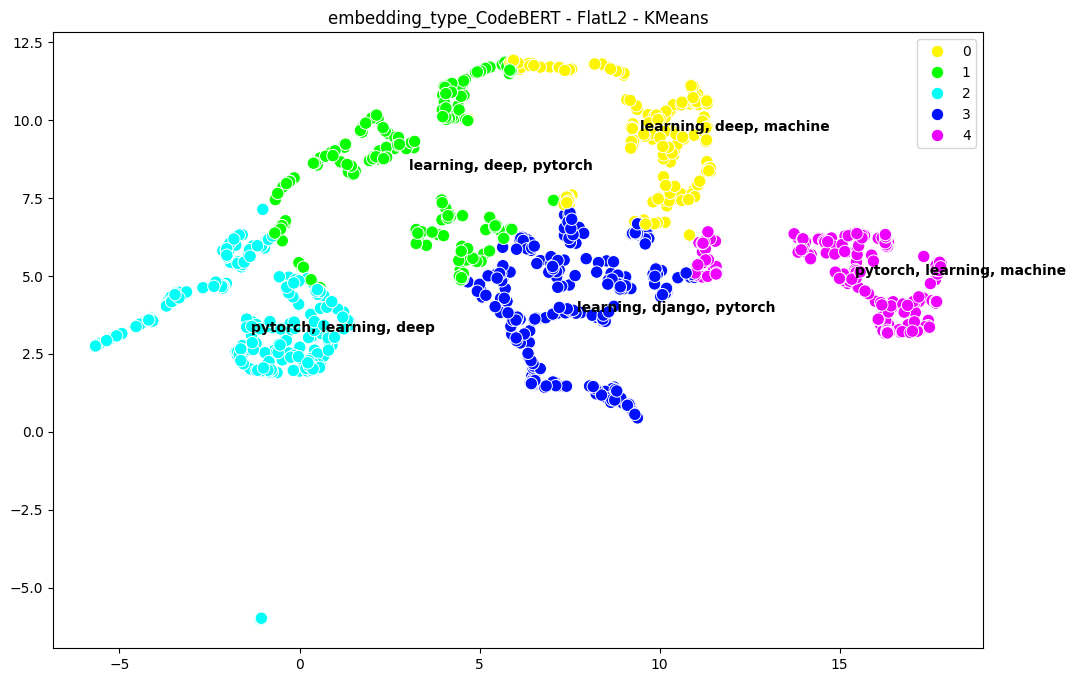

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


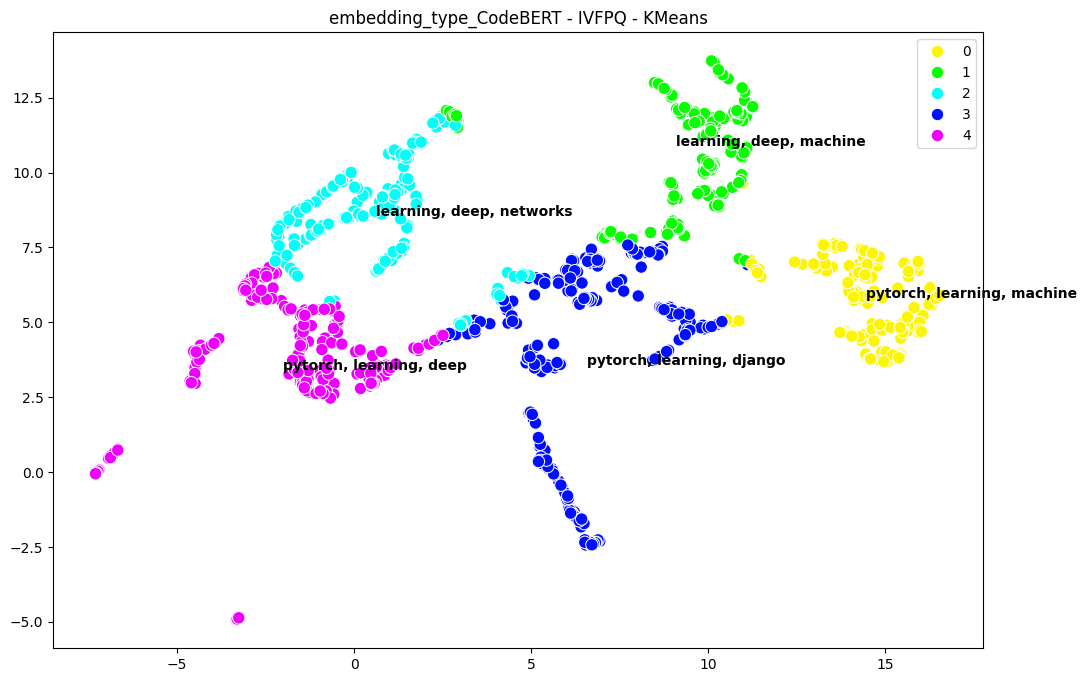

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


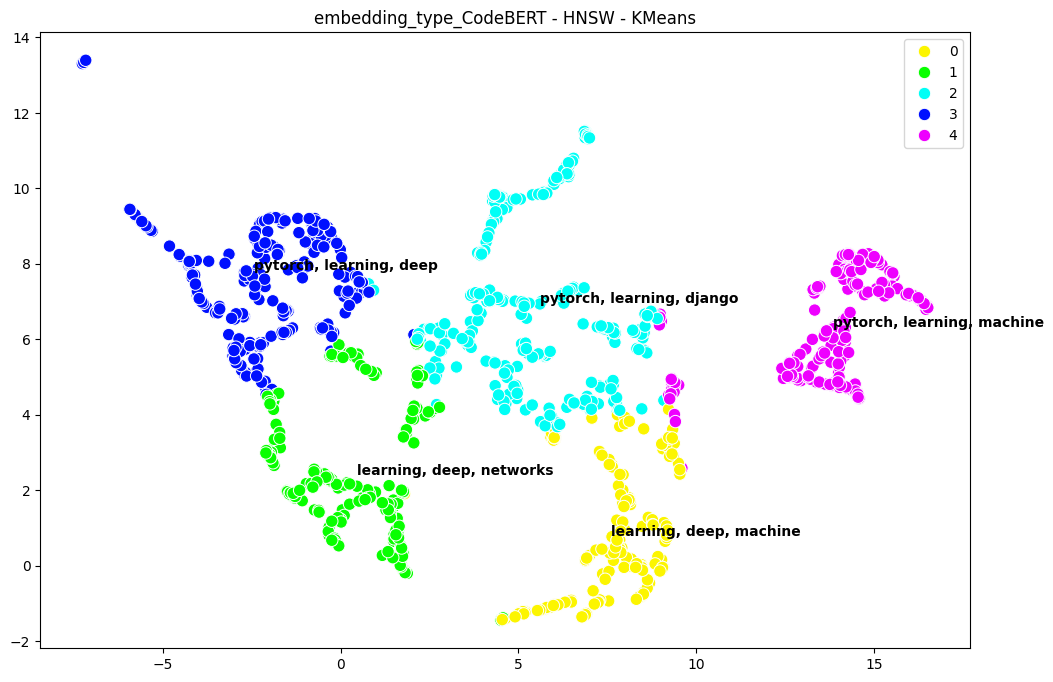

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


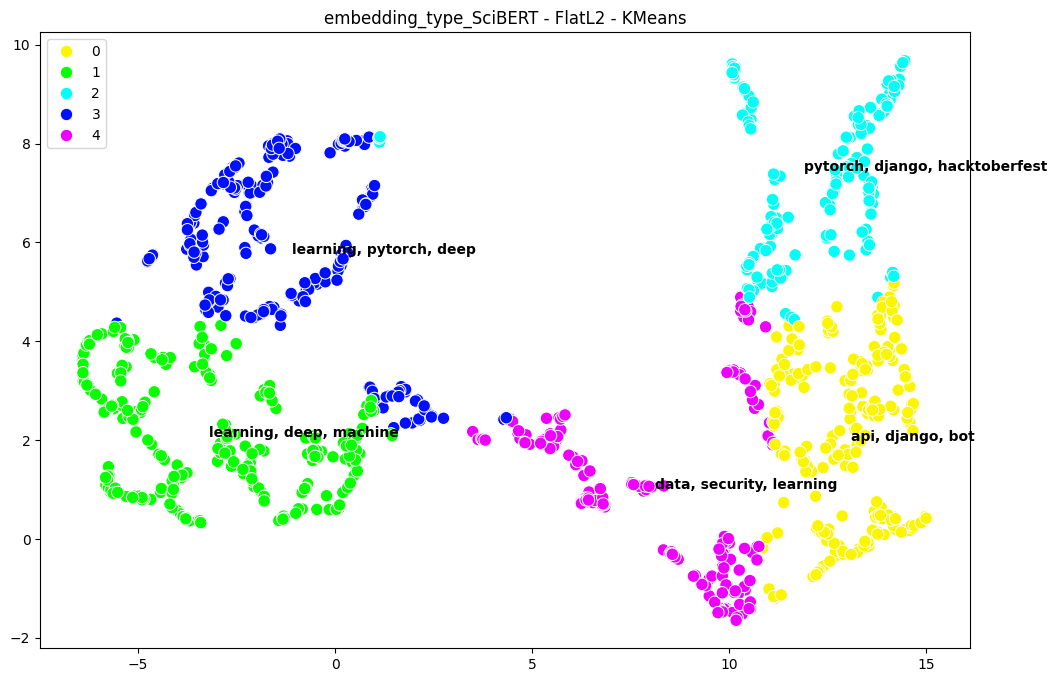

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


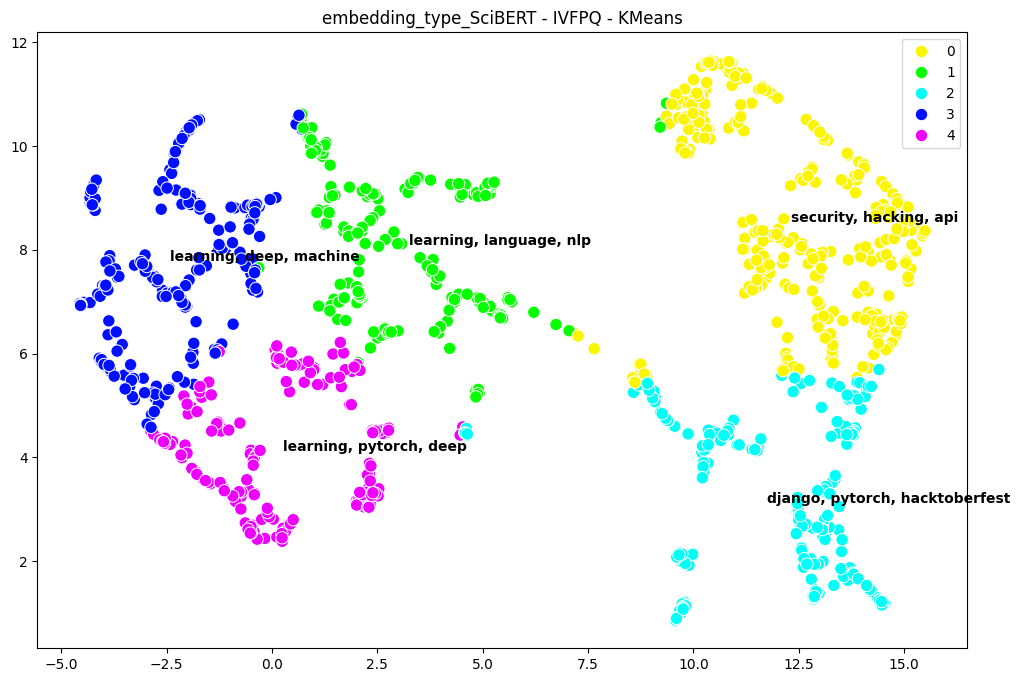

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


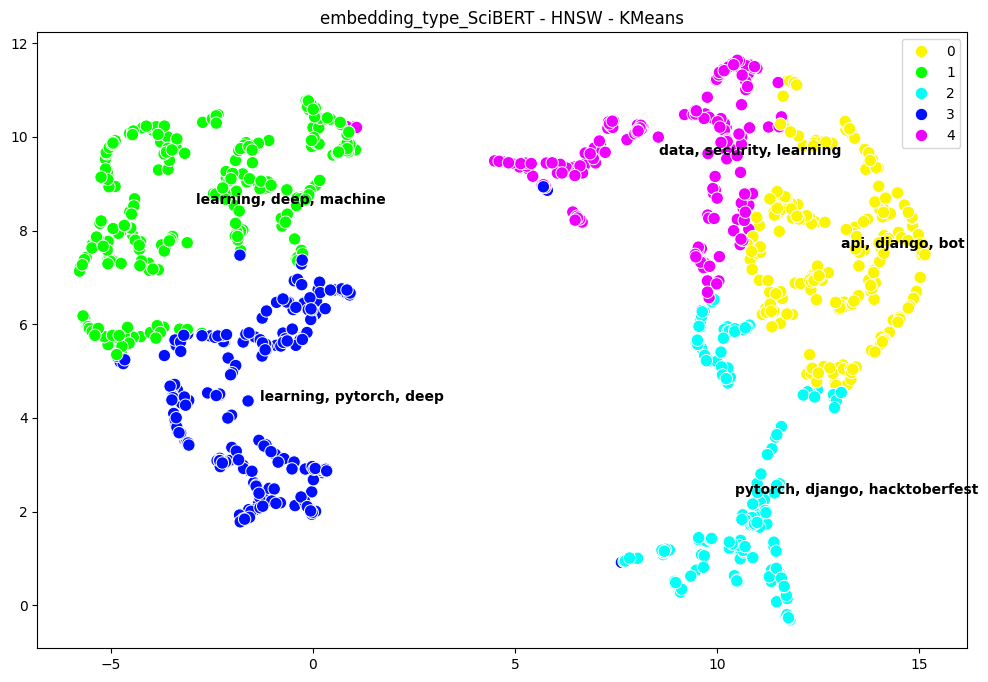

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


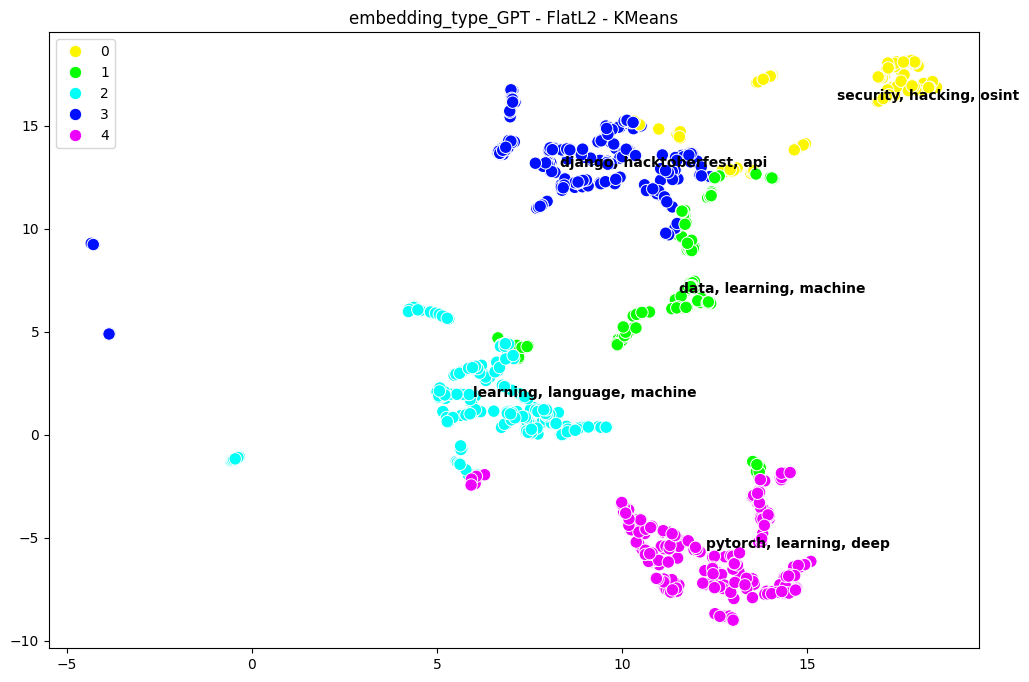

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


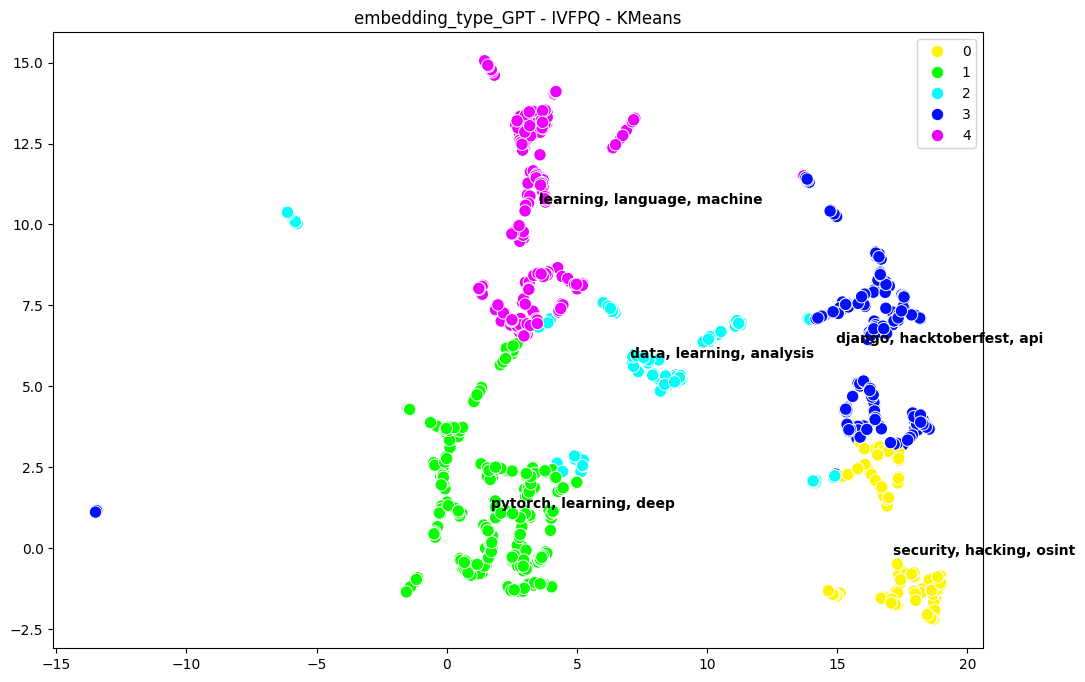

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


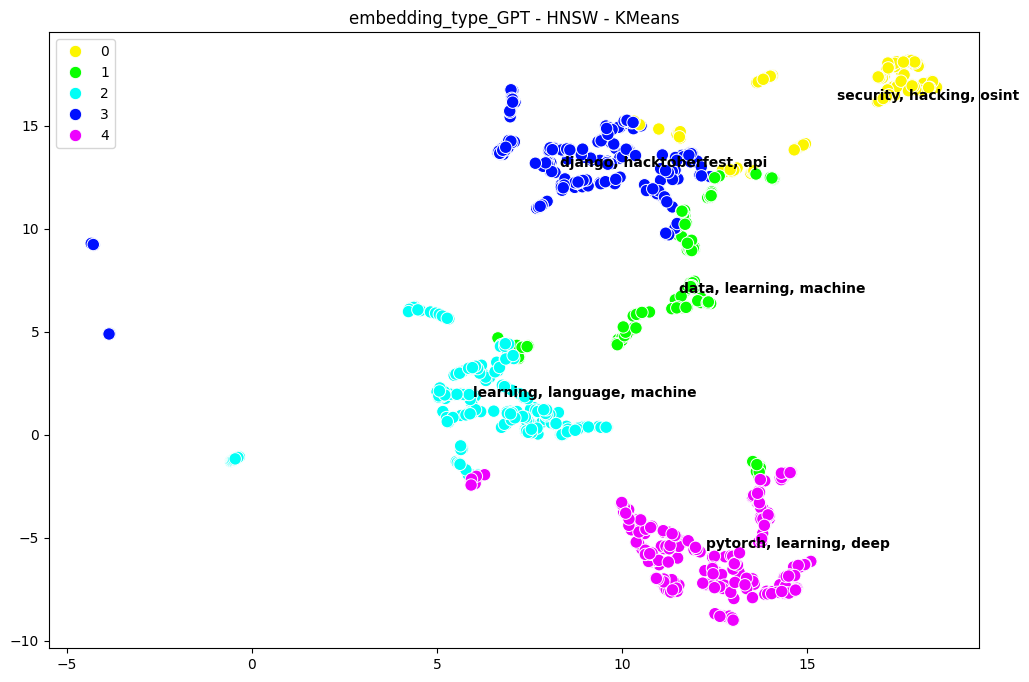


All results saved to: plots/clustering_results.xlsx


In [ ]:
embedding_columns = ['embedding_type_CodeBERT', 'embedding_type_SciBERT', 'embedding_type_GPT']
index_types = ['FlatL2', 'IVFPQ', 'HNSW']
sample_results_df = visualize_all_combinations_with_clustering(sample_df, embedding_columns, index_types)

In [ ]:
sample_results_df.sort_values(by='Davies_Bouldin_Index').sort_values(by='Silhouette_Score')

,Embedding,Index_Type,Silhouette_Score,Davies_Bouldin_Index
3,embedding_type_SciBERT,FlatL2,0.393840,0.934203
5,embedding_type_SciBERT,HNSW,0.395904,0.913736
0,embedding_type_CodeBERT,FlatL2,0.409560,0.775524
4,embedding_type_SciBERT,IVFPQ,0.412022,0.815527
1,embedding_type_CodeBERT,IVFPQ,0.412197,0.764253
2,embedding_type_CodeBERT,HNSW,0.416364,0.751133
7,embedding_type_GPT,IVFPQ,0.458032,0.741408
6,embedding_type_GPT,FlatL2,0.461400,0.728311
8,embedding_type_GPT,HNSW,0.461400,0.728311


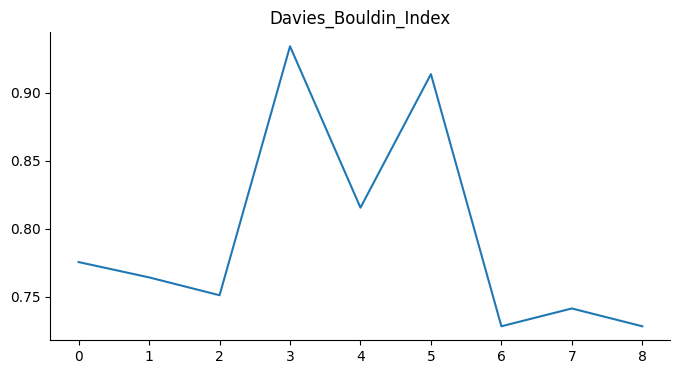

In [ ]:
sample_results_df['Davies_Bouldin_Index'].plot(kind='line', figsize=(8, 4), title='Davies_Bouldin_Index')
plt.gca().spines[['top', 'right']].set_visible(False)

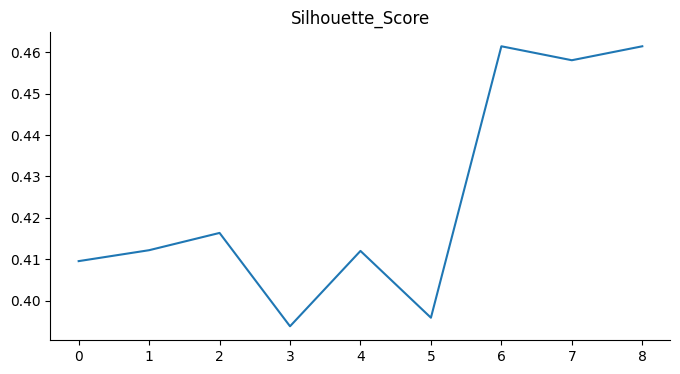

In [ ]:
sample_results_df['Silhouette_Score'].plot(kind='line', figsize=(8, 4), title='Silhouette_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

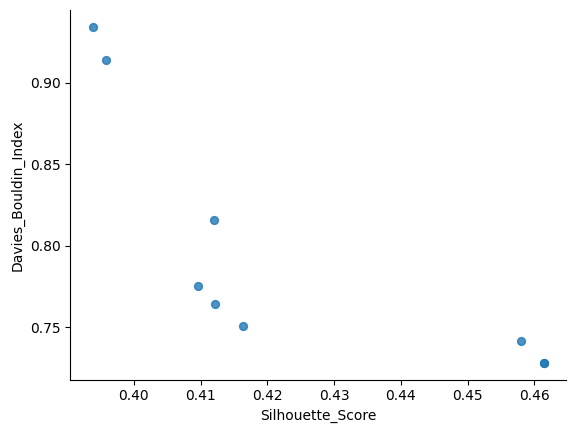

In [ ]:
sample_results_df.plot(kind='scatter', x='Silhouette_Score', y='Davies_Bouldin_Index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
sample_results_df[sample_results_df['Davies_Bouldin_Index']<0.8].sort_values(by='Silhouette_Score')

,Embedding,Index_Type,Silhouette_Score,Davies_Bouldin_Index
0,embedding_type_CodeBERT,FlatL2,0.409560,0.775524
1,embedding_type_CodeBERT,IVFPQ,0.412197,0.764253
2,embedding_type_CodeBERT,HNSW,0.416364,0.751133
7,embedding_type_GPT,IVFPQ,0.458032,0.741408
6,embedding_type_GPT,FlatL2,0.461400,0.728311
8,embedding_type_GPT,HNSW,0.461400,0.728311


### All Data Process

In [ ]:
embeded_df = generate_embeddings(clean_df, "GPT")

Generating Embeddings for GPT: 100%|██████████████████████████████| 117/117 [03:46<00:00,  1.93s/it]


In [ ]:
# embeded_df = embeded_df[["Name",	"Description",	"URL",	"Created At",
#                          "Updated At",	"Size",	"Stars", "Topics",
#                          "Overlap_Score",	"Common_Words",	"Year",	"embedding_type_GPT"]]

In [ ]:
embedding_columns = ['embedding_type_GPT']
index_types = ['HNSW']
embeded_df = process_all_indices(embeded_df, embedding_columns, index_types, output_folder="indexes", full_data=True)
mlflow.end_run()

In [ ]:
embeded_df.head()

,Name,Description,URL,Created At,Updated At,Size,Stars,Topics,Overlap_Score,Common_Words,Year,embedding_type_GPT,index
0,PyPOTS,toolboxlibrary data mining partially observed ...,https://github.com/WenjieDu/PyPOTS,2022-03-29 14:22:47,2023-09-25 04:20:18,7812,438,"classification, clustering, data mining, forec...",37,"['data', 'forecasting', 'incomplete', 'irregul...",2022,"[-0.013563501875932178, -0.011892540694414989,...",<faiss.swigfaiss_avx512.IndexHNSWFlat; proxy o...
1,changedetection.io,best simplest free open source website change ...,https://github.com/dgtlmoon/changedetection.io,2021-01-27 16:03:30,2023-09-21 11:00:40,6801,11908,"back in stock, change alert, change detection,...",27,"['change', 'defacement', 'detection', 'monitor...",2021,"[-0.01138204051801678, -0.007720453165301621, ...",<faiss.swigfaiss_avx512.IndexHNSWFlat; proxy o...
2,swarmlib,repository implements swarm optimization algor...,https://github.com/HaaLeo/swarmlib,2018-11-04 16:47:18,2023-09-20 12:39:17,201738,373,"aco, ant colony optimization, artificial bee c...",25,"['algorithm', 'algorithms', 'ant', 'artificial...",2018,"[0.014197298053074927, 0.009144729759095712, -...",<faiss.swigfaiss_avx512.IndexHNSWFlat; proxy o...
3,instagrapi-rest,restful api wrapper instagram private api,https://github.com/subzeroid/instagrapi-rest,2021-03-15 10:01:47,2023-09-23 10:20:03,127,333,"instagram, instagram api, instagram bot, insta...",25,"['api', 'instagram', 'private']",2021,"[-0.03370784115837259, -0.016761097523772712, ...",<faiss.swigfaiss_avx512.IndexHNSWFlat; proxy o...
4,scrapydweb,web app scrapyd cluster scrapy log analysis au...,https://github.com/my8100/scrapydweb,2018-09-30 19:11:44,2023-09-24 04:19:48,3196,2817,"dashboard, log analysis, log parsing, scrapy, ...",24,"['analysis', 'cluster', 'log', 'monitor', 'scr...",2018,"[-0.0024521956917585223, -0.000882586372968102...",<faiss.swigfaiss_avx512.IndexHNSWFlat; proxy o...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


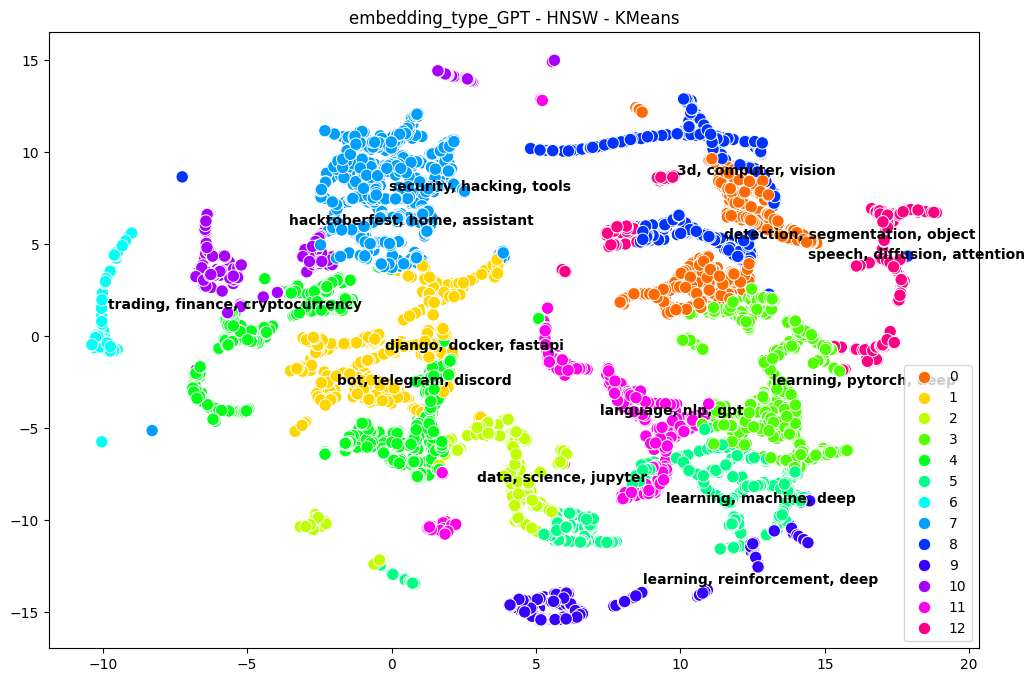


All results saved to: plots/clustering_results.xlsx


In [ ]:
results_df = visualize_all_combinations_with_clustering(clean_df, embedding_columns, index_types, k=13)

In [ ]:
results_df

,Embedding,Index_Type,Silhouette_Score,Davies_Bouldin_Index
0,embedding_type_GPT,HNSW,0.40595,0.79184


# Load Index LangChain retriever

In [ ]:
from langchain.vectorstores.faiss import FAISS
from langchain.docstore import InMemoryDocstore
from langchain.schema import Document

embedding_model = OpenAIEmbeddings(model = "text-embedding-ada-002")

faiss_index = faiss.read_index("/content/drive/MyDrive/GitHubRepositoriesProject/saved_data/index.index")


docs = []
for i, row in clean_df.iterrows():
    content = ", ".join(row["Topics"]) if isinstance(row["Topics"], list) else row["Topics"]
    metadata = {
        "name": row["Name"],
        "url": row["URL"],
        "description": row["Description"],
        "stars": row["Stars"],
        "Year": row["Year"]
    }
    docs.append(Document(page_content=content, metadata=metadata))


docstore = InMemoryDocstore({str(i): doc for i, doc in enumerate(docs)})
index_to_docstore_id = {i: str(i) for i in range(len(docs))}

vectorstore = FAISS(
    embedding_function=embedding_model,
    index=faiss_index,
    docstore=docstore,
    index_to_docstore_id=index_to_docstore_id
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 30})


# Query

In [ ]:
from langchain.tools import Tool


def search_github_projects(query: str, min_year=None, min_stars=None, top_k=5, sort_by="relevance"):

    results = retriever.invoke(query)

    filtered = []
    for doc in results:
        meta = doc.metadata
        if min_year and meta.get("Year", 0) < min_year:
            continue
        if min_stars and meta.get("stars", 0) < min_stars:
            continue
        filtered.append(doc)

    if sort_by == "latest":
        filtered = sorted(filtered, key=lambda d: clean_df.loc[clean_df["Name"] == d.metadata["name"], "Updated At"].values[0], reverse=True)
    elif sort_by == "stars":
        filtered = sorted(filtered, key=lambda d: d.metadata.get("stars", 0), reverse=True)

    if top_k:
        filtered = filtered[:top_k]

    output = ""
    for doc in filtered:
        meta = doc.metadata
        output += f"Name: {meta['name']}\n"
        output += f"Description: {meta['description']}\n"
        output += f"Stars: {meta['stars']}\n"
        output += f"URL: {meta['url']}\n\n"

    return "Final Answer:\n" + output.strip()




In [ ]:
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI

search_tool = Tool.from_function(
    func=search_github_projects,
    name="GitHubSearch",
    description="Search GitHub projects by topic. Input should be a short user query like 'transformers for time series'"
)

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


In [ ]:
response = agent.invoke({"input": "Find GitHub projects related to real-time anomaly detection"})
print(response["output"])




> Entering new AgentExecutor chain...
I should use the GitHubSearch tool to search for projects related to real-time anomaly detection.
Action: GitHubSearch
Action Input: query='real-time anomaly detection'
Observation: Final Answer:
Name: adtk
Description: toolkit rule basedunsupervised anomaly detection time series
Stars: 967
URL: https://github.com/arundo/adtk

Name: banpei
Description: anomaly detection singular spectrum transformationsst
Stars: 296
URL: https://github.com/tsurubee/banpei

Name: pysad
Description: streaming anomaly detection framework outlier detection streaming data
Stars: 200
URL: https://github.com/selimfirat/pysad

Name: Anomaly-Transformer
Description: code release anomaly transformer time series anomaly detection association discrepancy iclr
Stars: 434
URL: https://github.com/thuml/Anomaly-Transformer

Name: ano_pred_cvpr2018
Description: official implementation future frame prediction anomaly detection new cvpr
Stars: 411
URL: https://github.com/StevenLiuW

In [ ]:
response = agent.invoke({"input": "Find GitHub projects related RAG LLM and NLP."})
print(response["output"])



> Entering new AgentExecutor chain...
I should use GitHubSearch to search for projects related to RAG LLM and NLP.
Action: GitHubSearch
Action Input: query='RAG LLM NLP'
Observation: Final Answer:
Name: languagemodels
Description: explore large language models computer ram
Stars: 1083
URL: https://github.com/jncraton/languagemodels

Name: KR-BERT
Description: korean bert pre trained models kr bert tensorflow pytorch
Stars: 186
URL: https://github.com/snunlp/KR-BERT

Name: SceneGraphParser
Description: toolkit parsing captions natural language scene graphs symbolic representations
Stars: 432
URL: https://github.com/vacancy/SceneGraphParser

Name: fairseq-gec
Description: source code improving grammatical error correction pre training copy augmented architecture unlabeled data
Stars: 237
URL: https://github.com/kanyun-inc/fairseq-gec

Name: webarena
Description: code repo webarena realistic web environment building autonomous agents
Stars: 317
URL: https://github.com/web-arena-x/webare